In [15]:
import fastai.vision.all
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import time

In [16]:
FUNC_KIND=3
def Func(x):
  #NOTE: Switch the function to be learned.
  global FUNC_KIND
  if FUNC_KIND==0:  return x
  if FUNC_KIND==1:  return (x[:,0]**2).reshape((-1,1))
  if FUNC_KIND==2:  return (3.0-x[:,0]).reshape((-1,1))
  if FUNC_KIND==3:  return (x[:,0]+3.0*np.sin(x[:,0])).reshape((-1,1))
  if FUNC_KIND==4:  return np.where(x[:,0]**2<1.0, 3.0, 0.0).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, f, noise=1.0e-10):
  data_x= np.random.uniform(xmin,xmax,size=(N_sample,1))
  data_y= f(data_x) + np.random.normal(scale=noise,size=(N_sample,1))
  return data_x,data_y

In [17]:
xmin,xmax= -5.0, 5.0
N_sample= 200
#NOTE: Adjust the sample size and noise level.
data_x,data_y= GenerateSample(xmin, xmax, N_sample, Func, noise=0.5)
#Convert data to torch variables.
data_x= torch.autograd.Variable(torch.from_numpy(data_x).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch and epoch sizes.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x.shape[0])
N_train= round(data_x.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x[idxes[N_train:]], data_y[idxes[N_train:]])
# dl_train= torch.utils.data.DataLoader(
#       dataset=dset_train,
#       batch_size=N_batch,
#       shuffle=True,
#       num_workers=2)
# dl_test= torch.utils.data.DataLoader(
#       dataset=dset_train,
#       batch_size=N_batch,
#       shuffle=True,
#       num_workers=2)
#Create fastai dataloaders from torch dataloaders.
dls= fastai.data.core.DataLoaders.from_dsets(dset_train, dset_test, bs=N_batch)

In [18]:
class TRegNN1(torch.nn.Module):
  def __init__(self):
    super(TRegNN1,self).__init__()
    self.lin1= torch.nn.Linear(in_features=1, out_features=1, bias=True)
  def forward(self, x):
    x= self.lin1(x)
    return x

def DefRegNN2():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(200, 100),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(100, 1),
          )

def DefRegNN3():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN4():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN5(p=0.02):
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )

In [19]:
#NOTE: Switch the NN definition.
#Setup a neural network.
#net= TRegNN1()
#net= DefRegNN2()
#net= DefRegNN3()
#net= DefRegNN4()
net= DefRegNN5()

In [20]:
learn= fastai.vision.all.Learner(dls, net,  loss_func=fastai.vision.all.MSELossFlat(), metrics=fastai.vision.all.rmse)

In [21]:
learn.summary()

Sequential (Input shape: 50)
Layer (type)         Output Shape         Param #    Trainable 
                     50 x 200            
Linear                                    400        True      
ReLU                                                           
Dropout                                                        
Linear                                    40200      True      
ReLU                                                           
Dropout                                                        
Linear                                    40200      True      
ReLU                                                           
Dropout                                                        
Linear                                    40200      True      
ReLU                                                           
Dropout                                                        
____________________________________________________________________________
                    

SuggestedLRs(valley=0.0012022644514217973)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
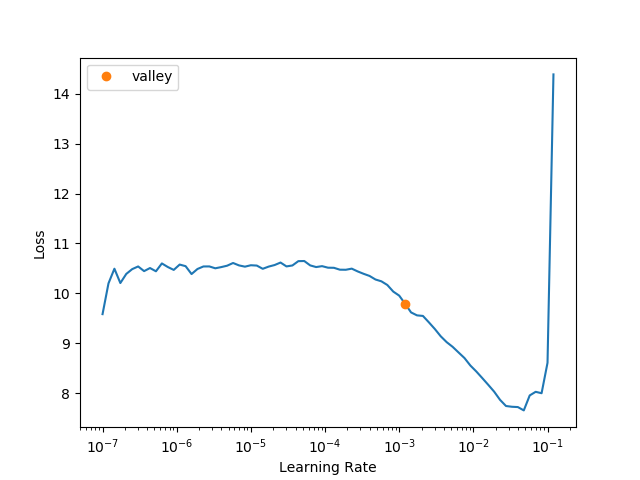

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(30, 0.0012)

epoch,train_loss,valid_loss,_rmse,time
0,10.476059,12.406042,3.522221,00:00
1,10.452707,12.154089,3.486271,00:00
2,10.284283,11.675257,3.416908,00:00
3,9.958836,10.799030,3.286188,00:00
4,9.567423,8.913466,2.985543,00:00
5,8.924078,5.615127,2.369626,00:00
6,8.221174,4.429320,2.104595,00:00
7,7.686099,4.754342,2.180445,00:00
8,7.167387,4.858666,2.204238,00:00
9,6.745677,3.890735,1.972495,00:00


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
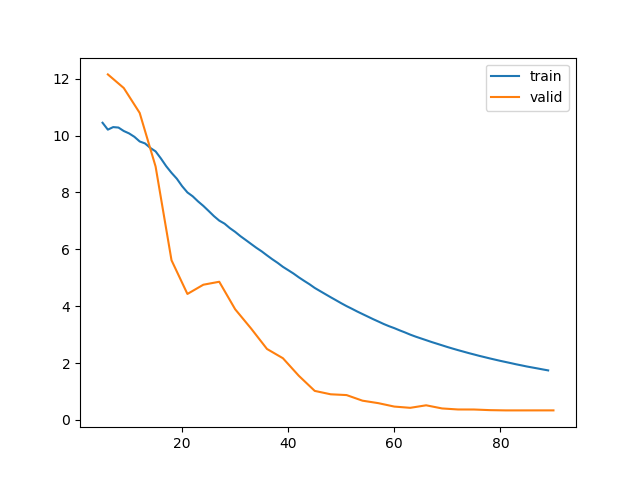

In [24]:
%matplotlib widget
learn.recorder.plot_loss()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
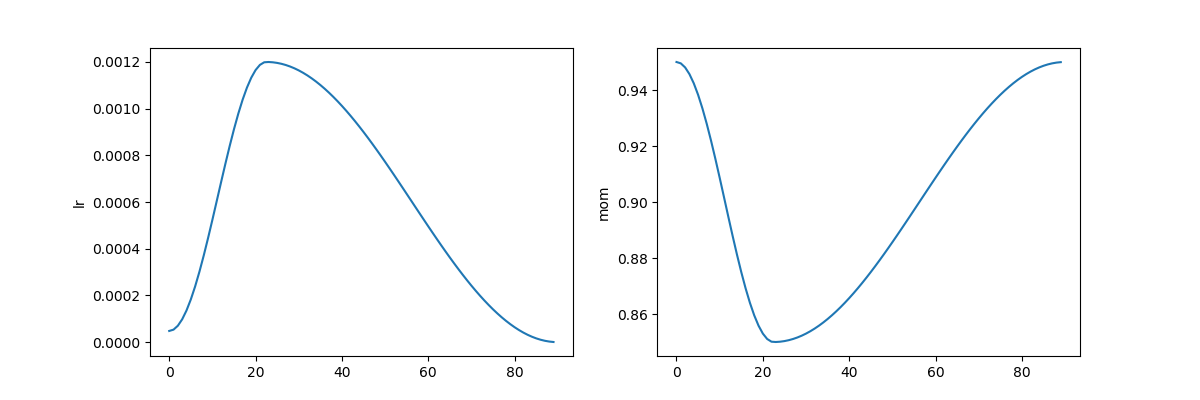

In [25]:
%matplotlib widget
learn.recorder.plot_sched()

In [40]:
x= torch.from_numpy(np.random.uniform(xmin,xmax,size=(1,1))).float()
print(f'x={x}')
with learn.no_bar(): print(f'  learn.predict(x)={learn.predict(x)[1]}')
net.eval()
with torch.no_grad(): print(f'  net(x)={net(x)}')
print()

x= dls.valid_ds[0]
print(f'x={x}')
with learn.no_bar(): print(f'  learn.predict(x)={learn.predict(x)[1]}')
# dls.valid_ds[0]
net.eval()
with torch.no_grad(): print(f'  net(x)={net(x[0])}')

x=tensor([[2.2483]])
  learn.predict(x)=tensor([4.3554])
  net(x)=tensor([[4.3554]])

x=(tensor([-3.8868]), tensor([-0.9492]))
  learn.predict(x)=tensor([-2.0385])
  net(x)=tensor([-2.0385])


In [41]:
x= torch.from_numpy(np.random.uniform(xmin,xmax,size=(3,1))).float()
print(f'x={x}')
with learn.no_bar(): print(f'  learn.predict(x)={learn.predict((x,torch.zeros(x.shape[0])))[1]}')  #torch.zeros(...) is a dummy label (necessary)
net.eval()
with torch.no_grad(): print(f'  net(x)={net(x)}')
print()

x= dls.valid_ds[:3]
print(f'x={x}')
with learn.no_bar(): print(f'  learn.predict(x)={learn.predict(x)[1]}')
# dls.valid_ds[0]
net.eval()
with torch.no_grad(): print(f'  net(x)={net(x[0])}')

x=tensor([[1.0306],
        [3.2362],
        [2.6697]])
  learn.predict(x)=tensor([[3.7589],
        [2.9421],
        [3.8278]])
  net(x)=tensor([[3.7589],
        [2.9421],
        [3.8278]])

x=(tensor([[-3.8868],
        [-1.7507],
        [-2.0780]]), tensor([[-0.9492],
        [-5.4539],
        [-4.3423]]))
  learn.predict(x)=tensor([[-2.0385],
        [-4.6469],
        [-4.5657]])
  net(x)=tensor([[-2.0385],
        [-4.6469],
        [-4.5657]])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
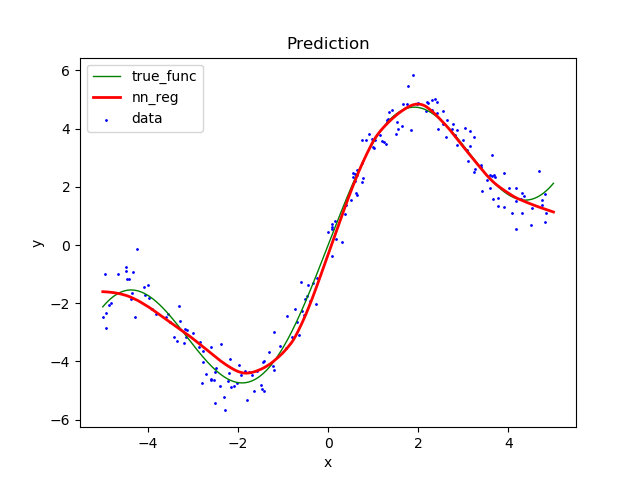

In [26]:
#Plot with net
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1)

true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x, data_y, 1, color='blue', label='data')

net.eval()  # evaluation mode; disabling dropout.
true_x_var= torch.from_numpy(true_x).float()
ax_pred.plot(true_x, net(true_x_var).data.cpu(), color='red', linewidth=2, label='nn_reg')

ax_pred.set_title('Prediction')
ax_pred.set_xlabel('x')
ax_pred.set_ylabel('y')
ax_pred.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
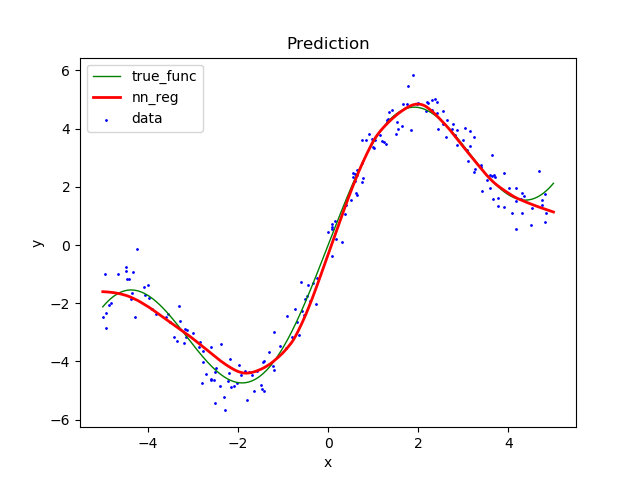

In [27]:
#Plot with learn
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1)

true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x, data_y, 1, color='blue', label='data')

true_x_var= torch.from_numpy(true_x).float()
ax_pred.plot(true_x, learn.predict((true_x_var,torch.zeros(true_x_var.shape[0])))[1], color='red', linewidth=2, label='nn_reg')

ax_pred.set_title('Prediction')
ax_pred.set_xlabel('x')
ax_pred.set_ylabel('y')
ax_pred.legend()